# Experiments for the paper "Informative Path Planning for Dynamic Environments
* Target: TBD

In [1]:
# allow imports from the main source directory
import sys
sys.path.append('..')
import logging
logging.basicConfig(level=logging.WARNING)

import pathlib

import pickle
import gzip as compress
import copy
import matplotlib.pyplot as plt
import matplotlib.lines as lines
# configuring the fonts such that no Type 3 fonts are used
# requirement for ICRA
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["figure.autolayout"] = True

import numpy as np
import timeit
import warnings

from InformationModel import StoredObservationIM
from WaterberryFarm import create_wbfe, WaterberryFarm, MiniberryFarm, WBF_IM_DiskEstimator, WBF_IM_GaussianProcess, WBF_Score_WeightedAsymmetric, get_datadir
from WbfExperiment import action_precompute_environment, action_load_environment, action_run_multiday, get_geometry, graph_env_im, graph_robot_path_day, graph_scores, graph_scores_per_day
from Policy import FollowPathPolicy, RandomWaypointPolicy
from PathGenerators import find_fixed_budget_spiral, generate_lawnmower, find_fixed_budget_lawnmower, generate_spiral_path, find_fixed_budget_spiral

logging.getLogger().setLevel(logging.WARNING)

# notebook-specific directory for experiments etc.
experiment_dir = pathlib.Path(get_datadir(), "DynamicEnvironmentPaper")
experiment_dir.mkdir(exist_ok=True)

In [2]:
# Precompute the environments
precompute_time = 50
# typenames = ["Miniberry-10", "Miniberry-30", "Miniberry-100", "Waterberry"]
typenames = ["Miniberry-10","Miniberry-30", "Miniberry-100"]
time_start_environment = 6

# typenames = ["Waterberry"]
# typenames = ["Miniberry-100"]
for typename in typenames:
    action_precompute_environment({"geometry": typename, "precompute-time": precompute_time})

# Plot environment

Function to plot the state of the environment at various days. 

In [6]:
def graph_environments(geometry = "Miniberry-30", start_day = 6, days_to_plot = {6, 9, 12, 15, 21}):
    choices = {}
    # precompute-environment with precompute-time = 0 is just loading it
    choices["geometry"] = geometry
    choices["result-basedir"] = experiment_dir
    choices["timesteps_per_day"] = 500 
    choices["time_start_environment"] = start_day
    results = action_load_environment(choices)
    wbfe = results["wbfe"]

    fig, axis = plt.subplots(3, len(days_to_plot), figsize=(18,9))

    row = 0
    for i in range(0, choices["time_start_environment"] + 15 + 1):
        if i in days_to_plot:
            graph_env_im(wbfe, None, ax_env_tylcv=axis[0, row], ax_env_ccr=axis[1, row], ax_env_soil=axis[2, row], title_string = "{label} " + f"day {i}")
            row = row + 1
        wbfe.proceed(1.0)
    plt.show()

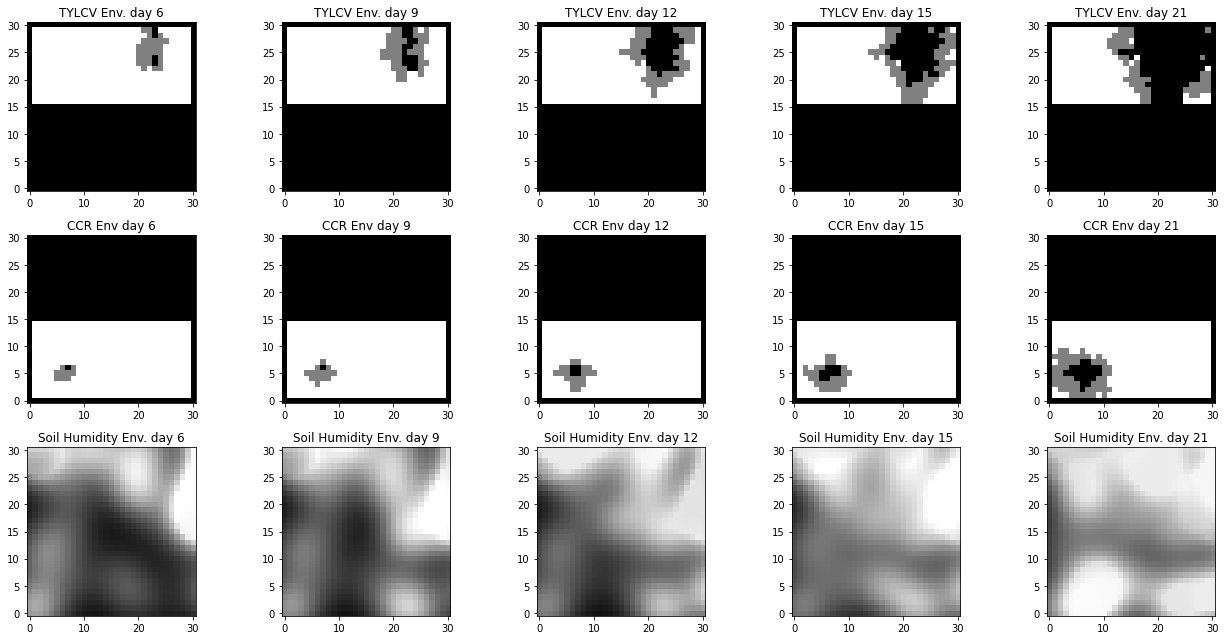

In [7]:
graph_environments()

## Graph the results of a multi-day experiment
A combined plot of the experiments. It allows us to plot the trajectories on different days, the model at the end, and the evolution of the score in different days and accross the interval

In [8]:




def graph_multi_day_experiment(results, graphfilename="DynamicResults.pdf"):
    # First trial: let us just plot the trajectory on day 1 and day 7
    fig, ((ax_path_1, ax_path_7, ax_score_per_day, ax_score_all)) = plt.subplots(1, 4, figsize=(16,4))
    graph_robot_path_day(results, 1, ax_path_1)
    graph_robot_path_day(results, 7, ax_path_7)
    graph_scores_per_day(results, ax_score_per_day)
    graph_scores(results, ax_score_all)



## Compare random waypoint and lawnmower in multi-day experiments
Perform the experiments for different policies differently parameterized. 

RandomWaypointPolicy
/home/lboloni/Documents/Hackingwork/__Temporary/2022-01-15-MREM_data/DynamicEnvironmentPaper/res_Miniberry-30_1M_RandomWaypoint-Seed0
day 1
day 2
day 3
day 4
day 5
day 6
day 7
day 8
day 9
day 10
day 11
day 12
day 13
day 14
day 15


NameError: name 'lines' is not defined

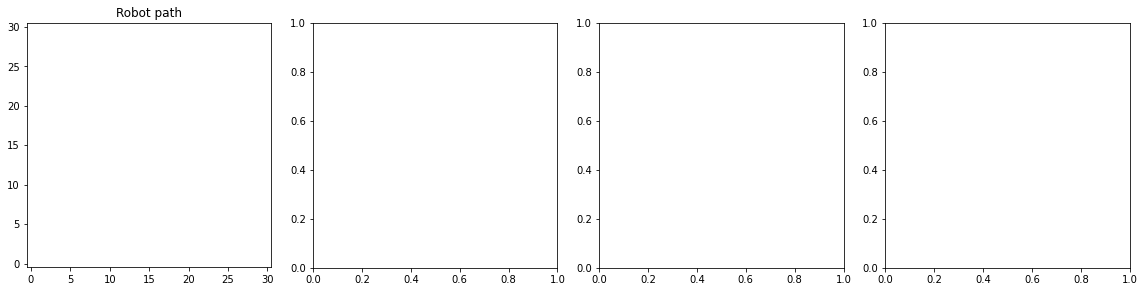

In [9]:
default_choices = {"geometry": "Miniberry-30", "result-basedir": experiment_dir}
default_choices["velocity"] = 1
default_choices["timesteps-per-day-override"] = 500 # 500, 1000
default_choices["score-resolution"] = 10
default_choices["time-start-environment"] = 6

# if force_run is false, we do not re-run an already run policy 
force_run = False
policies = []

# a random waypoint policy
geo = get_geometry(default_choices["geometry"])
policy = RandomWaypointPolicy(vel = 1, low_point = [geo["xmin"], geo["ymin"]], high_point = [geo["xmax"], geo["ymax"]], seed = 0)  
policy.name = "RandomWaypoint-Seed0"
policies.append(policy)

 # a lawnmower policy that covers the target area in one day uniformly
geo = get_geometry(default_choices["geometry"])
path = find_fixed_budget_lawnmower([0,0], geo["xmin"], geo["xmax"], geo["ymin"], geo["ymax"], geo["velocity"], time = geo["timesteps-per-day"])
policy = FollowPathPolicy(vel = geo["velocity"], waypoints = path, repeat = True)
policy.name = "FixedBudgetLawnmower"
policies.append(policy)

for policy in policies:
    print(policy)
    # do a dryrun, to get the path to the cached values
    choices = copy.copy(default_choices)
    choices["policy-code"] = policy
    choices["policy-name"] = policy.name
    choices["dryrun"] = True
    choices["estimator-name"] = "AD"
    choices["estimator-code"] = WBF_IM_DiskEstimator(geo["width"], geo["height"])
    choices["score-code"] = WBF_Score_WeightedAsymmetric()

    results = action_run_multiday(choices)
    path = results["results-path"]
    print(path)
    # avoid re-running experiments
    if not path.exists() or force_run:
        choices["dryrun"] = False
        results = action_run_multiday(choices)
    else:
        with compress.open(path, "rb") as f:
            results = pickle.load(f)
    graph_multi_day_experiment(results, f"daily-summary-{results['policy-name']}-{results['estimator-name']}.pdf")